The purpose of this notebook is to demonstrate how to utilize some of these functions. To avoid issues with Jupyter notebook imports, 
I'll simply add in the relatively small library below. 

In [5]:
def generate_synthetic_data(k_true, stoich, initial_conc, time_span, noise_level=0.01):
    import numpy as np
    clean_data = solve_reactive_system(
        elementary_irreversible_reactive_system,
        initial_conc,
        time_span,
        k_true,
        stoich
    )
    
    noisy_data = clean_data + np.random.normal(0, noise_level, clean_data.shape)
    return noisy_data


def elementary_irreversible_rate_law(t, concentrations, k, stoich):
    import numpy as np
    conc_array = np.clip(np.array(concentrations), 1e-12, None)  # Avoid zero or negative values
    powers = -np.array(stoich)  # Flip signs so powers are positive
    rate = k * np.prod(conc_array ** powers)
    return rate

def elementary_irreversible_reactive_system(conc, t,k,stoich):
    rate = elementary_irreversible_rate_law(t, conc, k, stoich)
    return [rate * coeff for coeff in stoich]

def elementary_reversible_rate_law(t, forward_concentrations, reverse_concentrations, k, Keq, stoich_forward, stoich_reverse):
    import numpy as np
    forward_conc_array = np.clip(np.array(forward_concentrations), 1e-12, None)
    reverse_conc_array = np.clip(np.array(reverse_concentrations), 1e-12, None)
    forward_powers = np.array(stoich_forward)
    reverse_powers = np.array(stoich_reverse)
    
    rate_forward = np.prod(forward_conc_array ** forward_powers)
    rate_reverse = np.prod(reverse_conc_array ** reverse_powers)
    
    rate = k * (rate_forward - rate_reverse / Keq)
    return rate


def solve_reactive_system(
    elementary_irreversible_reactive_system, 
    initial_conc, 
    time_span, 
    k, 
    stoich, 
    plot=False, 
    species_names=None
):
    from scipy.integrate import odeint
    
    results = odeint(
        elementary_irreversible_reactive_system,
        initial_conc,
        time_span,
        args=(k, stoich)
    )
    
    if plot:
        import matplotlib.pyplot as plt
        num_species = len(initial_conc)
        if species_names is None:
            species_names = [f"Species {i+1}" for i in range(num_species)]
        
        for i in range(num_species):
            plt.plot(time_span, results[:, i], label=species_names[i])
        
        plt.xlabel("Time")
        plt.ylabel("Concentration")
        plt.title("Concentration vs. Time")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    
    return results

def reaction_model_to_fit(t, k, stoich, initial_conc):
    from scipy.integrate import odeint
    result = odeint(
        elementary_irreversible_reactive_system,
        initial_conc,
        t,
        args=(k, stoich)
    )
    return result[:, 0]  # Fit to species A (you can change this)



def fit_reaction_to_data(t, data, stoich, initial_conc, k_guess=0.1):
    from scipy.optimize import curve_fit
    def wrapper(t, k):
        return reaction_model_to_fit(t, k, stoich, initial_conc)
    
    popt, pcov = curve_fit(wrapper, t, data, p0=[k_guess])
    return popt[0], pcov


__Example 1__

This shows solving an elementary reactive system. In this case, the reaction is A + 2B --> C. The reaction is assumed to be irreversible, and the k value is known. First, we must enter our inputs

In [6]:
import numpy as np
species = ['A', 'B']
initial_conc = [1.0, 2] #Initial concentration (mol/L)
stoich = [-1, -2]  # reactants consumed, so use negative
k = 0.1 #Reaction rate constant
time_span = np.linspace(0, 100, 100) #Total time, expressed as an Array.

Then, we can call our solve_reactive_system function. As long as we specify the assumed reaction model (Elementary irreversible), the function should handle the rest. We've asked it to output a plot of both species in this case. 

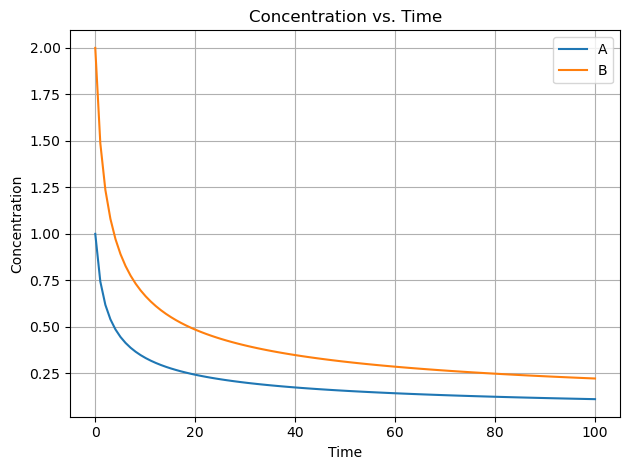

In [8]:
concentrations = solve_reactive_system(elementary_irreversible_reactive_system, initial_conc, time_span, k, stoich, plot=True, species_names = species)

Using nothing more than initial concentrations, stoichiometry, and the known reaction model, this library allows us to solve for the concentrations of both chemical species vs time. It does this by keeping the rate laws in differential form, allowing the model to be generalizable to any order of elementary reaction in any reactant concentration. 

__Example #2__

Now, we want to see how our curve fitting library works. To do this, we will first generate synthetic data. Generating synthetic data is unnecessary for the practicing Chemical Engineer, but having the built in function makes validation of code much easier, as well as helps users to become familiar with how to use this library. 


In [10]:
import matplotlib.pyplot as plt
# Define reaction system
stoich = [-1, -2]             # A + 2B -> products
initial_conc = [1.0, 2.0]     # Initial concentrations of A and B
k_true = 0.2                  # True rate constant
time_span = np.linspace(0, 50, 100)  # Time range for simulation

# --- Step 1: Generate noisy synthetic data ---
synthetic_data = generate_synthetic_data(
    k_true=k_true,
    stoich=stoich,
    initial_conc=initial_conc,
    time_span=time_span,
    noise_level=0.01           # Adjust this to simulate more/less noise
)

AFter generating the synthetic data, we will fit our curve.

In [ ]:
# --- Step 2: Fit model to species A (index 0) ---
fitted_k, covariance = fit_reaction_to_data(
    t=time_span,
    data=synthetic_data[:, 0],       # Use only species A data
    stoich=stoich,
    initial_conc=initial_conc,
    k_guess=0.1
)

For the sake of generating a pretty plot, I curve fit the true data as well. 

True k:   0.2
Fitted k: 0.2042


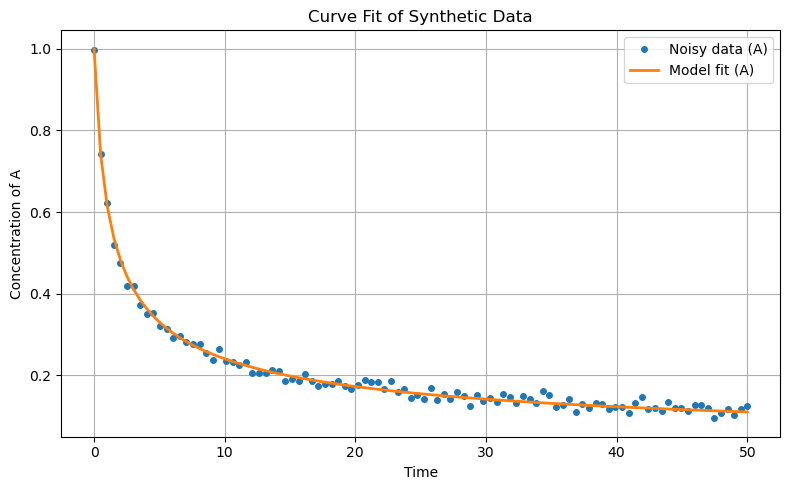

In [12]:
# --- Step 3: Print and compare results ---
print(f"True k:   {k_true}")
print(f"Fitted k: {fitted_k:.4f}")

# --- Step 4: Visualize fit vs. noisy data ---
fitted_conc = reaction_model_to_fit(
    t=time_span,
    k=fitted_k,
    stoich=stoich,
    initial_conc=initial_conc
)

plt.figure(figsize=(8, 5))
plt.plot(time_span, synthetic_data[:, 0], 'o', markersize=4, label='Noisy data (A)')
plt.plot(time_span, fitted_conc, '-', linewidth=2, label='Model fit (A)')
plt.xlabel("Time")
plt.ylabel("Concentration of A")
plt.title("Curve Fit of Synthetic Data")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

We can see that our estimator did a wonderful job, estimating a k value that accurately fits this data!